<a href="https://colab.research.google.com/github/GeorgeKonstantinosDimou/Skroutz/blob/main/thesisTradML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the required libraries

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from IPython.display import Markdown
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from tqdm import tqdm
from google.colab import files
import time
import os

# Dataset loading

In [ ]:
ds = pd.read_csv("/content/drive/MyDrive/Πτυχιακή /Πτυχιακή/datasets/original.csv")
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  float64
 3   nameOrig        1048575 non-null  object 
 4   oldbalanceOrg   1048575 non-null  float64
 5   newbalanceOrig  1048575 non-null  float64
 6   nameDest        1048575 non-null  object 
 7   oldbalanceDest  1048575 non-null  float64
 8   newbalanceDest  1048575 non-null  float64
 9   isFraud         1048575 non-null  int64  
 10  isFlaggedFraud  1048575 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 88.0+ MB


##General info/Statistics

In [ ]:
print(ds['isFraud'].value_counts(),'\n')
print(ds.nunique(),'\n')
print(ds['isFlaggedFraud'].value_counts())
print("isFlaggedFraud column contains only 0's and hence will be dropped in the preprocessing")

In [ ]:
plt.figure(figsize=(10, 5))
sns.heatmap(ds.corr(), annot=True, cmap='hot')

In [ ]:
from numpy.core.multiarray import result_type
plt.figure(figsize=(10, 8))
plt.pie(ds.type.value_counts().values,labels=ds.type.value_counts().index,  autopct='%.0f%%')
plt.title("Transaction Type")
plt.show()

print("\n")
result = ds.groupby('type')['isFraud'].value_counts()
print(result)
print("Only two type of categories contain fraudulent transactions all the other are not usefull")

#Dataset processing

In [ ]:
ds.drop(columns="isFlaggedFraud", inplace = True)
ds = ds[~(ds['type'].isin(['CASH_IN', 'DEBIT', 'PAYMENT']))]

#make the dataframe into a csv to upload it into Neo4j
ds.to_csv('output_preProcessed.csv', index=False)
files.download('output_preProcessed.csv')

#One hot encoding
encoder = {}
for i in ds.select_dtypes('object').columns:
    encoder[i] = LabelEncoder()
    ds[i] = encoder[i].fit_transform(ds[i])
#print(ds)

X = ds.drop('isFraud', axis=1)
y = ds['isFraud']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Stratified sampling & Training

In [ ]:
def train(clf_dictionary: dict, clfier: str):

  clf_pipeline = Pipeline(
      [('feature_selection', SelectKBest(f_classif, k=9)),
      ('scaler', StandardScaler()),
      ('resampler1', SMOTE(sampling_strategy='minority', random_state=42)),
      ('resampler2', RandomUnderSampler(sampling_strategy='all', random_state=42)),
      ('clf', clf_dictionary[clfier]['method']())],
      #verbose=True
      )

  params_grid = clf_dictionary[clfier]['params_grid']

  skf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  grid_search = sklearn.model_selection.GridSearchCV(clf_pipeline, params_grid, scoring=['precision', 'recall'], refit='precision', cv=skf)

  grid_search.fit(X, y)

  display(Markdown(
      "### Καλύτερα αποτελέσματα μέσω cross validation για {}:\n".format(clf_dictionary[clfier]['name']) +
      "{}".format(grid_search.best_params_) + "<br>" +
      "**Best score:** {:.3f}".format(grid_search.best_score_)
  ))
  return grid_search, skf

# Testing

In [ ]:
def test(clf_dictionary: dict, clfier: str, grid_search, skf):

  time_needed = time.time()
  best_params = {k.split('__')[1]: v for k, v in grid_search.best_params_.items()}

  best_clf = clf_dictionary[clfier]['method'](**best_params)

  display(Markdown("### Αποτελέσματα {}:\n".format(clf_dictionary[clfier]['name'])))
  for i, (train_index, test_index) in enumerate(skf.split(X, y)):
      display(Markdown("####Fold {}####".format(i+1)))

      X_train, y_train = X.iloc[train_index], y.iloc[train_index]
      X_test, y_test = X.iloc[test_index], y.iloc[test_index]

      #X_temp_resampled, y_temp_resampled = knn_pipeline['resampler1'].fit_resample(X_train, y_train) #use resampler1
      #X_resampled, y_resampled = knn_pipeline['resampler2'].fit_resample(X_temp_resampled, y_temp_resampled) #use resampler2
      #best_clf.fit(X_resampled, y_resampled) #fit the classifier using the resampled data
      #y_pred = best_clf.predict(X_resampled)

      #non-resampled fit/predict
      best_clf.fit(X_train, y_train)
      y_pred = best_clf.predict(X_test)

      conf_matr = confusion_matrix(y_test, y_pred)

      display(Markdown(
      "**Precision**: {:.2f}".format(precision_score(y_test, y_pred)) + "<br>" +
      "**Recall**: {:.2f}".format(recall_score(y_test, y_pred)) + "<br>" +
      "**F1**: {:.2f}".format(f1_score(y_test, y_pred)) + "<br>" +
      "**Confusion matrix**:"
      ))

      print("\n".join([' '.join(['{:5}'.format(item) for item in row])
            for row in conf_matr]))
      #print(f"Elapsed time: {(time.time()-time_needed)/60} in seconds")

#Visualization

In [ ]:
def plotVis(grid_search):

  selected_mask = grid_search.best_estimator_.named_steps['feature_selection'].get_support()
  #feature_names = list(range(X.shape[1])) # Replace this with the actual feature names
  #selected_features = [feature_names[i] for i in range(len(selected_mask)) if selected_mask[i]]
  selected_features = X.columns[selected_mask]

  #X.columns.to_numpy().tolist()
  display(Markdown(
      "**The selected features are**: {}".format(selected_features)
  ))
  #print("Selected features: ", selected_features)
  #selected_features = knn_pipeline.named_steps['feature_selection'].get_feature_names_out()
  #print(selected_features)
  print("\n")
  plt.figure(figsize=(10, 5))
  sns.heatmap(ds.loc[:, selected_features].corr(), annot=True, cmap='hot')

# Execution in main

### Καλύτερα αποτελέσματα μέσω cross validation για K-Nearest Neighbor:
{'clf__n_neighbors': 4, 'clf__weights': 'uniform'}<br>**Best score:** 0.185

### Αποτελέσματα K-Nearest Neighbor:


####Fold 1####

**Precision**: 0.77<br>**Recall**: 0.44<br>**F1**: 0.56<br>**Confusion matrix**:

91820    30
  128   101
Elapsed time: 0.1756010929743449 in seconds


####Fold 2####

**Precision**: 0.88<br>**Recall**: 0.43<br>**F1**: 0.58<br>**Confusion matrix**:

91837    13
  131    98
Elapsed time: 0.3463475743929545 in seconds


####Fold 3####

**Precision**: 0.77<br>**Recall**: 0.39<br>**F1**: 0.52<br>**Confusion matrix**:

91824    27
  138    90
Elapsed time: 0.5018084327379863 in seconds


####Fold 4####

**Precision**: 0.88<br>**Recall**: 0.48<br>**F1**: 0.62<br>**Confusion matrix**:

91836    15
  118   110
Elapsed time: 0.675246512889862 in seconds


####Fold 5####

**Precision**: 0.85<br>**Recall**: 0.44<br>**F1**: 0.58<br>**Confusion matrix**:

91832    18
  128   100
Elapsed time: 0.8605469981829326 in seconds




**The selected features are**: Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest'],
      dtype='object')

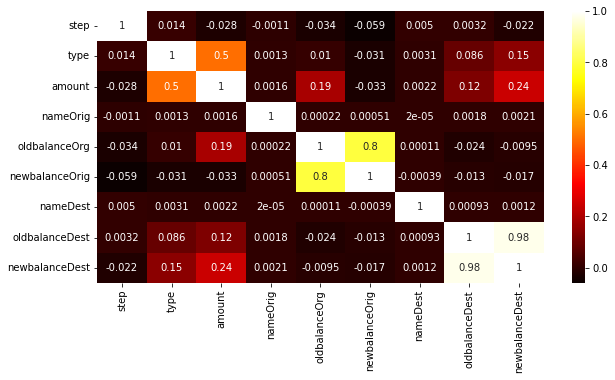

In [ ]:
def main():

  classifiers_dict = {
    'clf1': {
        'name': 'K-Nearest Neighbor',
        'method': KNeighborsClassifier,
        'params_grid': { 'clf__n_neighbors': [4],
                         'clf__weights':   ['uniform']
        }
    },
    'clf2': {
        'name': 'Logistic Regression',
        'method': LogisticRegression,
        'params_grid': { 'clf__C': np.logspace(-6, -5, 10)
        }
    },
    'clf3': {
        'name': 'SVM',
        'method' : SVC,
        'params_grid': { 'clf__C': [1, 10, 20]
                            #'clf__kernel': ['linear', 'poly'],
                            #'clf__degree': [2],
                            #'clf__gamma': ['scale']
        }
    },
    'clf4': {
        'name': 'Naive_Bayes',
        'method': GaussianNB,
        'params_grid': { 'clf__var_smoothing': [1e-9, 1e-8, 1e-7],
                         'clf__priors': [None, [0.4, 0.6], [0.3, 0.7]]
        }
    },
    'clf5': {
        'name': 'Decision_Tree',
        'method': DecisionTreeClassifier,
        'params_grid': { 'clf__criterion': ["gini", 'entropy', 'log_loss'],
                         'clf__max_leaf_nodes': [4, 5, 6]
        }
    },
    'clf6': {
        'name': 'Random_forest',
        'method': RandomForestClassifier,
        'params_grid': { 'clf__n_estimators': [50, 100, 150],
                         'clf__criterion': ['gini', "entropy"]
        }
    },
    'clf7': {
        'name': 'XGBoost',
        'method': XGBClassifier,
        'params_grid': { 'clf__n_estimators': range(50, 150, 50)
          }
      }
  }

  grid_search_results, stratifks = train(classifiers_dict, 'clf1')
  test(classifiers_dict, 'clf1', grid_search_results, stratifks)
  print("\n")
  plotVis(grid_search_results)

if __name__ == '__main__':
  main()